# SmolWords

We will first reverse the encoder model to reconstruct the raw images, then train a simple CNN on the EMNIST dataset to predict each letter in the image. Finally, we use a dictionary to help us form valid words.

In [1]:
!tar -xf smolwords.tar.xz

In [4]:
import os
import random
from pathlib import Path
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision import transforms, datasets
from torchvision.transforms import functional as F
from PIL import Image

import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda")
print("Using device:", device)
encoder = torch.jit.load("dist/encoder_only_cpu.pt", map_location=device)
encoder.eval()

Using device: cuda


/home/pwo/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:645: UserWarning: Can't initialize amdsmi - Error code: 34
  warnings.warn(f"Can't initialize amdsmi - Error code: {e.err_code}")


RecursiveScriptModule(
  original_name=Encoder
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (fc3): RecursiveScriptModule(original_name=Linear)
)

## 1. Decoder

Convolutional autoencoder decoder: converts 32-dim code back to the 28x28 image. 

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 256 * 7 * 7)

        self.decode = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),

            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid(),

            nn.Flatten(start_dim=1)      # ← flattens to (B, 28*28)
        )

    def forward(self, x):
        x = self.fc(x)                  # → (B, 256*7*7)
        x = x.view(-1, 256, 7, 7)       # → (B, 256, 7, 7)
        x = self.decode(x)              # → (B, 784)
        return x

In [7]:
decoder = Decoder().to(device)
optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-4)
criterion = nn.MSELoss()

compressed_path = "dist/dataset/compressed/"
raw_path = "dist/dataset/raw/"
compressed_files = sorted([f for f in os.listdir(compressed_path) if f[0] != '.'])

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# 1) Build a list of all (compressed_patch, raw_patch) file‐position pairs
class PatchPairDataset(Dataset):
    def __init__(self, compressed_dir, raw_dir, file_list):
        self.pairs = []
        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),               # gives [1, H, W], float32 in [0,1]
            transforms.Lambda(lambda t: t.view(-1)),  # flatten
        ])
        for fname in tqdm(file_list, desc="Indexing files"):
            comp = Image.open(os.path.join(compressed_dir, fname)).convert("L")
            raw   = Image.open(os.path.join(raw_dir, fname.replace("smol", "word"))).convert("L")
            w = comp.size[1]  # compressed_img.size = (32, word_len)
            for i in range(w):
                self.pairs.append((fname, i))

        self.compressed_dir = compressed_dir
        self.raw_dir = raw_dir

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        fname, i = self.pairs[idx]
        # load compressed patch
        comp = Image.open(os.path.join(self.compressed_dir, fname)).convert("L")
        patchC = comp.crop((0, i, 32, i+1))
        latent = self.to_tensor(patchC)  # shape [32]

        # load raw letter
        raw = Image.open(os.path.join(self.raw_dir, fname.replace("smol", "word"))).convert("L")
        letter = raw.crop((i*28, 0, (i+1)*28, 28))
        target = self.to_tensor(letter)  # shape [784]

        return latent, target

# 2) Instantiate dataset + dataloader
compressed_path = "dist/dataset/compressed"
raw_path        = "dist/dataset/raw"
files = compressed_files[:100]
ds = PatchPairDataset(compressed_path, raw_path, files)
loader = DataLoader(ds, batch_size=32)

# 3) Move model & criterion to GPU
decoder   = decoder.to(device)
criterion = criterion.to(device)

# 4) Training loop
EPOCHS = 100
for epoch in range(1, EPOCHS+1):
    total_loss = 0.0
    for batch_latent, batch_target in tqdm(loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        batch_latent = batch_latent.to(device)  # [B,32]
        batch_target = batch_target.to(device)  # [B,784]

        optimizer.zero_grad()
        output = decoder(batch_latent)          # [B,784]
        loss   = criterion(output, batch_target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_latent.size(0)

    avg_loss = total_loss / len(ds)
    print(f"Epoch {epoch}/{EPOCHS} — avg loss: {avg_loss:.6f}")


In [10]:
for file_name in tqdm(compressed_files, desc="Reconstructing"):
    compressed_img = Image.open(os.path.join(compressed_path, file_name)).convert("L")
    width, height = compressed_img.size  # Should be 32 x word_len
    out_img = Image.new("L", (28 * height, 28))

    for i in range(height):
        patch = compressed_img.crop((0, i, 32, i + 1))  # (32, 1)
        arr = np.array(patch).astype(np.float32).flatten() / 255.0
        x = torch.tensor(arr, dtype=torch.float32, device=device).unsqueeze(0)

        with torch.no_grad():
            reconstructed = decoder(x).reshape(28, 28).cpu().numpy()

        letter_img = Image.fromarray((reconstructed * 255).astype(np.uint8))
        out_img.paste(letter_img, (i * 28, 0))

    out_img.save(f"reconstructed/{file_name}")

Reconstructing: 100%|██████████| 5000/5000 [00:34<00:00, 144.14it/s]


## 2. EMNIST Dataset

Since we only care about lowercase letters, only choose them and cap each class by 3000 to avoid over-representation.
Then, do a 80-20 train-test split.

In [11]:
import torchvision

mapp = {}
class FilteredEMNISTRaw(Dataset):
    def __init__(self, train=True, split='byclass', cap_per_class=3000):
        base = datasets.EMNIST(
            root="data",
            split=split,
            train=train,
            download=True,

        )
        chars = base.classes
        by_label = {}
        for idx, (_, lab) in enumerate(zip(base.data, base.targets)):
            c = chars[lab]
            if 'a' <= c <= 'z':
                by_label.setdefault(lab.item(), []).append(idx)

        # cap each class
        self.selected = []
        for lab, idxs in by_label.items():
            random.shuffle(idxs)
            self.selected += idxs[:cap_per_class]
        self.selected.sort()

        # map old→new labels 0..N‑1
        used = sorted(by_label.keys())
        self.lab_map = {old: new for new, old in enumerate(used)}
        global mapp
        mapp = {new: chars[old] for new, old in enumerate(used)}
        self.num_classes = len(used)

        # transforms
        self.to_tensor = torchvision.transforms.ToTensor()
        self.base = base

    def __len__(self):
        return len(self.selected)

    def __getitem__(self, i):
        idx = self.selected[i]
        img = self.base.data[idx].unsqueeze(0).float().div(255).T.reshape(1, 28, 28)  # (1,28,28)
        lab = int(self.base.targets[idx].item())
        return img.to(device), self.lab_map[lab]

from torch.utils.data import ConcatDataset, random_split

# 1) instantiate both halves
train_part = FilteredEMNISTRaw(train=True)
test_part  = FilteredEMNISTRaw(train=False)

# 2) concatenate into one big dataset
ds_full = ConcatDataset([train_part, test_part])
print("Combined total examples:", len(ds_full))

# 3) 80/20 split
train_len = int(0.8 * len(ds_full))
val_len   = len(ds_full) - train_len
train_ds, val_ds = random_split(ds_full, [train_len, val_len])

print(f"Train / Val = {len(train_ds)} / {len(val_ds)}")

100%|██████████| 561753746/561753746 [00:06<00:00, 87769349.16it/s] 


Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw
Combined total examples: 98378
Train / Val = 78702 / 19676


In [12]:
train_ds[0][0].shape

/tmp/ipykernel_115541/2943774679.py:43: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3697.)
  img = self.base.data[idx].unsqueeze(0).float().div(255).T.reshape(1, 28, 28)  # (1,28,28)


torch.Size([1, 28, 28])

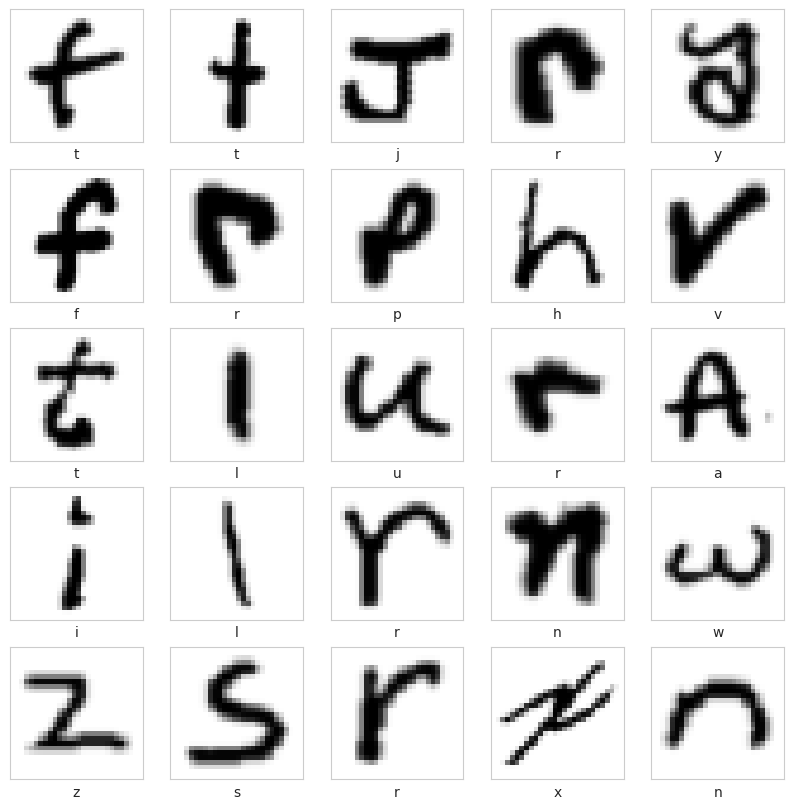

In [13]:
import math
display = 25
num_cells = math.ceil(math.sqrt(display))
plt.figure(figsize=(10,10))
for i in range(display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_ds[i][0].to('cpu').squeeze(), cmap=plt.cm.binary)
    plt.xlabel(mapp[train_ds[i][1]])
plt.show()

In [24]:
batch_size = 512

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)

## 3. Training

Just a simple CNN model will do. Fast and can get 90%+ accuracy.

In [25]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # → 32×28×28
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),                           # → 32×14×14
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),                                # → 32*14*14
            nn.Linear(32*14*14, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN(num_classes=26).to(device)

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [27]:
def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()
    total_loss, correct = 0, 0
    for xb, yb in tqdm(loader, desc="Train" if train else "Val  "):
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * xb.size(0)
        correct    += (preds.argmax(1) == yb).sum().item()
    acc = correct / len(loader.dataset)
    return total_loss / len(loader.dataset), acc

In [28]:
for epoch in range(1, 11):
    train_loss, train_acc = run_epoch(train_loader, train=True)
    val_loss,   val_acc   = run_epoch(val_loader,   train=False)
    print(f"Epoch {epoch:2d} | "
          f"Train Loss {train_loss:.3f}, Acc {train_acc:.3%} | "
          f"Val Loss {val_loss:.3f}, Acc {val_acc:.3%}")

Val  : 100%|██████████| 39/39 [00:02<00:00, 17.76it/s]


Epoch  1 | Train Loss 1.101, Acc 68.710% | Val Loss 0.594, Acc 82.908%


Val  : 100%|██████████| 39/39 [00:03<00:00, 12.89it/s]


Epoch  2 | Train Loss 0.502, Acc 85.069% | Val Loss 0.417, Acc 87.843%


Val  : 100%|██████████| 39/39 [00:03<00:00, 12.97it/s]


Epoch  3 | Train Loss 0.373, Acc 88.650% | Val Loss 0.350, Acc 89.342%


Val  : 100%|██████████| 39/39 [00:22<00:00,  1.72it/s]


Epoch  4 | Train Loss 0.316, Acc 90.141% | Val Loss 0.311, Acc 90.359%


Val  : 100%|██████████| 39/39 [00:03<00:00, 12.15it/s]


Epoch  5 | Train Loss 0.281, Acc 91.149% | Val Loss 0.290, Acc 90.852%


Val  : 100%|██████████| 39/39 [00:03<00:00, 11.68it/s]


Epoch  6 | Train Loss 0.259, Acc 91.642% | Val Loss 0.277, Acc 91.106%


Val  : 100%|██████████| 39/39 [00:03<00:00, 12.85it/s]


Epoch  7 | Train Loss 0.239, Acc 92.273% | Val Loss 0.266, Acc 91.370%


Val  : 100%|██████████| 39/39 [00:02<00:00, 13.47it/s]


Epoch  8 | Train Loss 0.224, Acc 92.672% | Val Loss 0.267, Acc 91.421%


Val  : 100%|██████████| 39/39 [00:02<00:00, 13.59it/s]


Epoch  9 | Train Loss 0.210, Acc 93.079% | Val Loss 0.257, Acc 91.650%


Val  : 100%|██████████| 39/39 [00:03<00:00, 11.98it/s]

Epoch 10 | Train Loss 0.197, Acc 93.461% | Val Loss 0.258, Acc 91.645%


In [29]:
torch.save(model.state_dict(), 'weights.pth')

## 4. Predicting

For each of the letters, store the top 3 predictions and their probabilities. This helps the dictionary better determine the word, as letters like 'I' and 'L' can be hard to distinguish.

In [30]:
# Cell: Fast batched strip prediction
import os, glob
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision.transforms import ToTensor

# 1) Build char_map once
base = datasets.EMNIST(root="data", split='byclass', train=False, download=True)
chars = base.classes
sel = [i for i,c in enumerate(chars) if ('a'<=c<='z')]
lab_map = {old: new for new,old in enumerate(sel)}
char_map = {new: chars[old] for old,new in lab_map.items()}

# 2) Prep
to_tensor = ToTensor()
model.eval()

results = {}
paths = sorted(glob.glob("reconstructed/*.png"))
for path in tqdm(paths):
    img = Image.open(path).convert("L")
    tensor = to_tensor(img)            # [1, H, W]
    _, H, W = tensor.shape
    n = W // 28
    if n == 0:
        continue

    # 3) Slice into tiles all at once
    # unfold dim=2 (W) into windows of size 28, step 28 → shape [1, H, n, 28]
    windows = tensor.unfold(2, 28, 28)           # [1,H,n,28]
    # permute to [n, 1, H, 28] then center‑crop H to 28 (assuming H=28)
    tiles = windows.permute(2, 0, 1, 3)          # [n,1,H,28]
    # if H>28, you could slice: tiles = tiles[..., :28, :]
    tiles = tiles[..., :28, :]                   # [n,1,28,28]

    # 4) Batch inference
    batch = tiles.to(device)                     # [n,1,28,28]
    with torch.no_grad():
        logits = model(batch)                    # [n, C]
        probs  = F.softmax(logits, dim=1)        # [n, C]
        topp, topi = probs.topk(3, dim=1)      # [n,3]

    # 5) Map to chars
    topp = topp.cpu()
    topi = topi.cpu()
    word_preds = []
    for pi, ii in zip(topp, topi):
        preds = [(char_map[int(i)], float(p)) for i,p in zip(ii, pi)]
        word_preds.append(preds)

    results[os.path.basename(path)] = word_preds

# 6) Display first 10
for fname, preds in list(results.items())[:10]:
    line = " | ".join(
        "".join(f"{c}({p:.2f}) " for c,p in letter_preds)
        for letter_preds in preds
    )
    print(f"{fname:20s} → {line}")


100%|██████████| 5000/5000 [00:08<00:00, 582.32it/s]

smol0000.png         → r(1.00) t(0.00) c(0.00)  | o(0.63) a(0.36) d(0.00)  | g(0.80) z(0.15) q(0.03)  | u(0.78) n(0.13) v(0.05)  | l(0.92) i(0.07) r(0.00)  | b(0.98) d(0.01) o(0.01)  | a(0.91) z(0.05) g(0.03)  | l(0.89) i(0.10) j(0.00)  | a(0.96) n(0.02) o(0.01)  | j(0.99) i(0.01) l(0.00)  | i(0.90) l(0.09) r(0.00) 
smol0001.png         → a(0.90) c(0.05) i(0.02)  | i(0.56) j(0.34) s(0.06)  | c(1.00) o(0.00) i(0.00)  | d(0.98) j(0.01) a(0.00)  | e(0.97) c(0.02) q(0.00)  | f(0.96) p(0.02) i(0.01) 
smol0002.png         → g(0.71) q(0.20) s(0.02)  | h(0.98) n(0.01) b(0.00)  | l(0.77) i(0.23) j(0.00)  | j(0.94) i(0.04) l(0.01)  | h(0.56) i(0.18) k(0.09)  | l(0.97) i(0.03) r(0.00) 
smol0003.png         → m(1.00) n(0.00) w(0.00)  | n(1.00) r(0.00) o(0.00)  | o(1.00) d(0.00) a(0.00)  | p(0.99) r(0.01) f(0.00)  | q(0.53) g(0.35) y(0.05)  | r(0.88) f(0.07) i(0.02) 
smol0004.png         → s(1.00) j(0.00) g(0.00)  | t(0.94) r(0.04) j(0.01)  | l(0.39) v(0.15) u(0.13)  | v(1.00) u(0.00) r(0.00)  | w(

## 5. Dictionary Check

We noticed the data actually contained some French and Italian words, so we included them for a total of 3 million words in our dictionary.
First, we try to form a word with only the letters that were detected, and choosing a valid word with the highest score. The score is defined as the product of the softmax probability for the candidate word across every letter position. If there are no valid words, and the highest valid word has a score below `threshold = 1e-8`, then we allow one letter to be arbitrarily modified and repeat the same process. Finally, if all valid words are below threshold, we simply return a word in the dictionary with the lowest hamming distance to the string formed by greedily concatenating the most likely letters at each position.

In [33]:
from wordfreq import top_n_list
dictionary = set(w.lower() for w in top_n_list("en", 20000000)) | set(w.lower() for w in top_n_list('it', 500000)) | set(w.lower() for w in top_n_list('fr', 500000))

In [34]:
from collections import defaultdict

lengths = set(len(preds) for preds in results.values())
candidates_by_len = {}
pos_index = {}

for L in lengths:
    words = [w for w in dictionary if len(w)==L]
    candidates_by_len[L] = words

    # positional index
    idx_L = [defaultdict(set) for _ in range(L)]
    for w in words:
        for i,c in enumerate(w):
            idx_L[i][c].add(w)
    pos_index[L] = idx_L

def best_word_fast_with_fallback(letter_preds, threshold=1e-8):
    L = len(letter_preds)
    idx = pos_index[L]

    # 1) Prune by intersection of top‑3 sets
    pruned = None
    for i, top3 in enumerate(letter_preds):
        # union of words that match any top‑3 char at position i
        union = set()
        for c,_ in top3:
            union |= idx[i].get(c, set())   # << use set() not ()
        pruned = union if pruned is None else pruned & union
        if not pruned:
            break

    # helper to score a word, penalizing missing letters by ε
    def score_word(w, epsilon=1e-6):
        score = 1.0
        for i,ch in enumerate(w):
            for c,p in letter_preds[i]:
                if c == ch:
                    score *= p
                    break
            else:
                score *= epsilon
        return score

    # 2) If we have exact matches, pick the best
    if pruned:
        best = max(pruned, key=score_word)
        if score_word(best) >= threshold:
            return best, score_word(best)

    # 3) Fallback: words off by exactly one letter
    near = []
    for w in candidates_by_len[L]:
        misses = 0
        for i,ch in enumerate(w):
            if all(c != ch for c,_ in letter_preds[i]):
                misses += 1
                if misses > 1:
                    break
        if misses == 1:
            near.append(w)
    if near:
        best = max(near, key=score_word)
        if score_word(best) >= threshold:
            return best, score_word(best)

    guess = ''.join(p[0][0] for p in letter_preds)

    # find minimal Hamming distance
    min_dist = L+1
    closest = []
    cands = candidates_by_len[L]
    for w in cands:
        dist = sum(ch1!=ch2 for ch1,ch2 in zip(w, guess))
        if dist < min_dist:
            min_dist = dist
            closest = [w]
        elif dist == min_dist:
            closest.append(w)

    # pick best‑scoring among the closest
    best, best_score = None, 0.0
    for w in closest:
        sc = score_word(w)
        if sc>best_score:
            best, best_score = w, sc

    return best, best_score

# Run on your results
final_preds = {}
for fname, preds in tqdm(results.items()):
    word, score = best_word_fast_with_fallback(preds)
    final_preds[fname] = (word, score)


100%|██████████| 5000/5000 [02:08<00:00, 38.97it/s] 


In [35]:
file_path = "dist/dataset/testcases.csv"
import pandas as pd
df = pd.read_csv(file_path)


# Update the 'word' column for rows after the first 100
for idx in df.index[100:]:
    fname = df.at[idx, 'compressed_file']  # adjust if your filename column has a different name
    # Look up the predicted word (first element of the tuple)
    if fname in final_preds:
        df.at[idx, 'word'] = final_preds[fname][0]
    else:
        df.at[idx, 'word'] = ''

# Save back to CSV (overwrites the original file)
df.to_csv('out.csv', index=False)